# Real-time human pose estimation with NVIDIA TensorRT model
Real time human pose estimation is interesting task. For this NVIDIA provides [handy toolkit](https://github.com/NVIDIA-AI-IOT/trt_pose).
For this experiment get and install it:
```bash
git clone https://github.com/NVIDIA-AI-IOT/trt_pose
cd trt_pose
sudo python3 setup.py install
```
They also provide couple of pre-trained models. Download faster [resnet18_baseline_att_224x224_A](https://drive.google.com/open?id=1XYDdCUdiF2xxx4rznmLb62SdOUZuoNbd) and put under `./models`


In [1]:
import os
import cv2
import json
import ipywidgets
import jetson.utils
import PIL.Image
import numpy as np
import torch
import time
import trt_pose.coco

from jetutils import SimpleTimer
from IPython.display import display
from sidecar import Sidecar
from torch2trt import TRTModule
import torchvision.transforms as transforms

In [2]:
MODEL_PATH = './models/resnet18_baseline_att_224x224_A_epoch_249_trt.pth'
MODEL_W = 224
MODEL_H = 224

with open('./trt_pose/tasks/human_pose/human_pose.json', 'r') as f:
    human_pose = json.load(f)

topology = trt_pose.coco.coco_category_to_topology(human_pose)

# colors for links starting from named keypoint (BGR)
COLOR_MAP = {
    'nose': (100,100,255),
    'eye': (100,150,255),
    'ear': (150,150,255),
    
    'neck': (255,100,100),
    'shoulder': (255,150,100),
    'elbow': (255,150,150),
    
    'ankle': (100,255,100),
    'knee': (100,255,150),
    'hip': (150,255,150)
}

For the first time only we need to convert the downloaded model weights into TensorRT.

In [3]:
if not os.path.exists(MODEL_PATH):
    import trt_pose.models
    import torch2trt
    totals = SimpleTimer()
    timer = SimpleTimer()
    with totals:
        MODEL_WEIGHTS = './models/resnet18_baseline_att_224x224_A_epoch_249.pth'
        num_parts = len(human_pose['keypoints'])
        num_links = len(human_pose['skeleton'])
        with timer:
            model = trt_pose.models.resnet18_baseline_att(num_parts, 2 * num_links).cuda().eval()
        print('model with {} parts and {} links generated in {} seconds'.format(num_parts,
                                                                                num_links,
                                                                                timer.time))
        with timer:
            model.load_state_dict(torch.load(MODEL_WEIGHTS))
        print('model weights loaded in {} secods'.format(timer.time))
        with timer:
            trt_model = torch2trt.torch2trt(model,
                                            [torch.zeros((1, 3, MODEL_H, MODEL_W)).cuda()],
                                            fp16_mode=True,
                                            max_workspace_size=1<<20)
        print('model converted to TensorRT in {} seconds'.format(timer.time))
        torch.save(trt_model.state_dict(), MODEL_PATH)
    print('total time {} seconds'.format(totals.time))
else:
    timer = SimpleTimer()
    with timer:
        trt_model = TRTModule()
        trt_model.load_state_dict(torch.load(MODEL_PATH))
    print('model loaded in {} seconds'.format(timer.time))

model loaded in 38.17882746900068 seconds


In [4]:
import threading
import traitlets
from trt_pose.parse_objects import ParseObjects
from collections import namedtuple
Keypoint = namedtuple('Keypoint', 'name x y')
KPLink = namedtuple('KPLink', 'x0 y0 x1 y1 color')
_timer = SimpleTimer()

class HumanPose(traitlets.HasTraits):
    input_frame = traitlets.Any()
    output_frame = traitlets.Any()
    
    image_width = traitlets.Integer()
    image_height = traitlets.Integer()
    width = traitlets.Integer(default_value=MODEL_W)
    height = traitlets.Integer(default_value=MODEL_H)
    
    draw_background = traitlets.Bool(default_value=True)
    draw_skeleton = traitlets.Bool(default_value=True)
    draw_labels = traitlets.Bool(default_value=False)
    
    _X = 1
    _Y = 0
    
    def __init__(self, model, topology, keypoints, 
                 *args, **kwargs):
        super(HumanPose, self).__init__(*args, **kwargs)
        self.input_frame = np.empty((self.image_height, self.image_width, 3), dtype=np.uint8)
        self.output_frame = np.empty((self.image_height, self.image_width, 3), dtype=np.uint8)
        self._running = False 
        self._model = model
        self._parse = ParseObjects(topology)
        self._topology = topology
        self._keypoints = keypoints
        self._link_colors = dict()
        for link in sorted([(int(topology[a][2]),
                             int(topology[a][3]))
                            for a in range(topology.shape[0])]):
            self._link_colors[link] = COLOR_MAP[keypoints[link[0]].split('_')[-1]]
        self._mean = torch.Tensor([0.485, 0.456, 0.406]).cuda()
        self._std = torch.Tensor([0.229, 0.224, 0.225]).cuda()
        self._device = torch.device('cuda')

    def _get_human_keypoints(self, humans, index, peaks):
        keypoints = []
        human = humans[0][index]
        C = human.shape[0]
        for j in range(C):
            k = int(human[j])
            if k >= 0:
                peak = peaks[0][j][k]
                keypoints.append(Keypoint(
                                          name=self._keypoints[j],
                                          x=round(float(peak[HumanPose._X]) * self.image_width),
                                          y=round(float(peak[HumanPose._Y]) * self.image_height)
                                         ))
        return keypoints

    def _get_keypoint_links(self, humans, index, peaks):
        links = []
        human = humans[0][index]
        K = self._topology.shape[0]
        for k in range(K):
            c_a = self._topology[k][2]
            c_b = self._topology[k][3]
            if human[c_a] >= 0 and human[c_b] >= 0:
                peak0 = peaks[0][c_a][human[c_a]]
                peak1 = peaks[0][c_b][human[c_b]]
                clink = (int(c_a), int(c_b))
                links.append(KPLink(
                    x0=round(float(peak0[HumanPose._X]) * self.image_width),
                    y0=round(float(peak0[HumanPose._Y]) * self.image_height),
                    x1=round(float(peak1[HumanPose._X]) * self.image_width),
                    y1=round(float(peak1[HumanPose._Y]) * self.image_height),
                    color=self._link_colors[clink] if clink in self._link_colors else (0,0,0)
                ))
        return links

    def _draw(self, image, counts, humans, peaks):
        dbg_str = ''
        for i in range (int(counts[0])):
            dbg_str = '\n\n'.join([dbg_str,'human {}:'.format(i)])
            keypoints = self._get_human_keypoints(humans, i, peaks)
            kplinks = self._get_keypoint_links(humans, i, peaks)
            if self.draw_skeleton:
                for link in kplinks:
                    cv2.line(image, (link.x0, link.y0), (link.x1, link.y1), link.color, 2)
            for keypoint in keypoints:
                dbg_str = '\n'.join([dbg_str,str(keypoint)])
                if self.draw_labels:
                    cv2.putText(image , '{}'.format(keypoint.name),
                                (keypoint.x + 5 + 2, keypoint.y + 5), 
                                cv2.FONT_HERSHEY_PLAIN, 1, (150, 150, 150), 1)
                cv2.circle(image, (keypoint.x, keypoint.y), 5, (240,240,240), 1)
        return dbg_str
                         
    def run_model(self):
        self._device = torch.device('cuda')
        with _timer:
            image = self.input_frame.copy()
            if self.draw_background:
                output_frame = self.input_frame.copy()
            else:
                output_frame = np.zeros((self.image_height, self.image_width, 3), dtype=np.uint8)

             # first scale input into model dimensions
            image = cv2.resize(image, (self.height, self.width))
            image = PIL.Image.fromarray(image.astype(np.uint8)).convert('RGB')
        
            # transform to torch tensor on CUDA device
            image_tensor = transforms.functional.to_tensor(image).to(self._device)
            image_tensor.sub_(self._mean[:, None, None]).div_(self._std[:, None, None])
            input_data = image_tensor[None, ...]

            # then use the ML model
            cmap, paf = self._model(input_data)
            cmap, paf = cmap.detach().cpu(), paf.detach().cpu()
            h_counts, humans, peaks = self._parse(cmap, paf)

            # finally draw object skeleton over image
            dbg_str = self._draw(output_frame, h_counts, humans, peaks)
            self.output_frame = output_frame
        return 'fps {}{}'.format(_timer.fps, dbg_str)

    @classmethod
    def validate(cls, model, topo, kp,img_path):
        data  = cv2.imread(img_path)
        instance = cls(model, topo, kp, image_height=data.shape[cls._Y], image_width=data.shape[cls._X])
        instance.input_frame = data
        print(instance.run_model())
        display(PIL.Image.fromarray(cv2.cvtColor(instance.output_frame, cv2.COLOR_BGR2RGB)))
        del instance
        


It is good practice to validate model and above HumanPose abstraction before actual real-time usage. Makes changes and improvements a lot of easier.

fps 0.27464716401542916

human 0:
Keypoint(name='nose', x=264, y=52)
Keypoint(name='right_eye', x=263, y=49)
Keypoint(name='right_ear', x=255, y=48)
Keypoint(name='left_shoulder', x=224, y=69)
Keypoint(name='right_shoulder', x=252, y=66)
Keypoint(name='right_elbow', x=276, y=57)
Keypoint(name='right_wrist', x=299, y=32)
Keypoint(name='left_hip', x=216, y=146)
Keypoint(name='right_hip', x=248, y=142)
Keypoint(name='right_knee', x=284, y=183)
Keypoint(name='right_ankle', x=313, y=229)
Keypoint(name='neck', x=237, y=68)

human 1:
Keypoint(name='left_ear', x=129, y=79)
Keypoint(name='right_ear', x=152, y=77)
Keypoint(name='left_shoulder', x=119, y=103)
Keypoint(name='right_shoulder', x=171, y=92)
Keypoint(name='left_elbow', x=96, y=119)
Keypoint(name='left_wrist', x=77, y=121)
Keypoint(name='left_hip', x=161, y=164)
Keypoint(name='right_hip', x=190, y=159)
Keypoint(name='left_knee', x=124, y=209)
Keypoint(name='right_knee', x=218, y=210)
Keypoint(name='left_ankle', x=115, y=268)
Keypoint(n

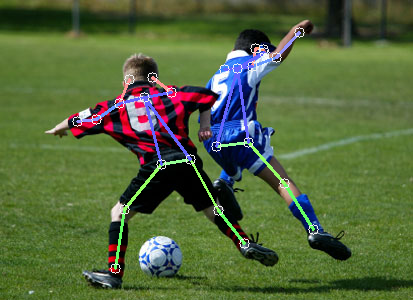

In [5]:
HumanPose.validate(trt_model, topology, human_pose['keypoints'], 'jetson-inference/data/images/humans_0.jpg')

And only then initialize camera steam so in case of errors it is not needed to clean gstreamer.

In [6]:
from jetutils import GstCamera, bgr8_to_jpeg
camera = GstCamera()

In [7]:
pose_model = HumanPose(trt_model, topology, human_pose['keypoints'],
                       image_height=camera.height, image_width=camera.width)

Then we make our common output display sidecar again

In [8]:
image_original = ipywidgets.Image(format='jpeg', width=camera.width, height=camera.height)
image_processed = ipywidgets.Image(format='jpeg', width=camera.width, height=camera.height)
image_original.value = bgr8_to_jpeg(np.zeros((camera.height, camera.width, 3), dtype=np.uint8))
image_processed.value = bgr8_to_jpeg(np.zeros((camera.height, camera.width, 3), dtype=np.uint8))


debug_out = ipywidgets.Textarea(value='',
                                disabled=True,
                                layout=ipywidgets.Layout(width='640px', height='520px'))
images_out = ipywidgets.HBox([image_original, image_processed])

select_background = ipywidgets.ToggleButton(value=True, description='background')
select_skeleton = ipywidgets.ToggleButton(value=True, description='skeleton')
select_labels = ipywidgets.ToggleButton(value=False, description='labels')
control_box = ipywidgets.HBox([ipywidgets.Label(value='Draw '),
                               select_background,
                               select_skeleton,
                               select_labels])

all_box = ipywidgets.VBox([images_out, control_box, debug_out])
_sidecar = Sidecar(title='output')
with _sidecar:
    display(all_box)

With traitlest it is so convenient to link traits of objects together.

In [9]:
traitlets.dlink((camera, 'value'), (image_original, 'value'), transform=bgr8_to_jpeg)
traitlets.dlink((pose_model,'output_frame'), (image_processed, 'value'), transform=bgr8_to_jpeg)

traitlets.dlink((select_background, 'value'), (pose_model, 'draw_background'))
traitlets.dlink((select_skeleton, 'value'), (pose_model, 'draw_skeleton'))
traitlets.dlink((select_labels, 'value'), (pose_model, 'draw_labels'))

def process(change):
    pose_model.input_frame = change['new']
    debug_out.value = pose_model.run_model()
    
camera.observe(process, names='value')
camera.running = True

In [ ]:
camera.running = False
camera.unobserve_all()

In [ ]:
del camera
del trt_model